In [34]:
# import time
# start = time.time()
import sys
from dimod import BinaryQuadraticModel
from dwave.system import LeapHybridSampler, EmbeddingComposite,DWaveSampler 
import pandas as pd
import numpy as np
import seaborn as sns
from distance_matrix_creator import *
import neal
import matplotlib.pyplot as plt

In [47]:
# np.set_printoptions(suppress=True,threshold= sys.maxsize, linewidth=1000,formatter={'float_kind':'{}'.format, 'all': lambda x: " {:.0f}. ".format(x)})
np.set_printoptions(linewidth=1000, suppress=True,threshold= sys.maxsize)
flow = pd.read_csv("flowmatrix.csv", header = None)
flow = (flow.to_numpy()/3)**5
# flow = np.round(flow)
flow = np.triu(flow)
flow = np.array(flow)
print(flow,"\n\n")


distance = distmatrix(9,9)
# distance = np.round(distance,decimals=3)
distance = np.triu(np.array(distance))
distance = (np.array(distance))#**3)/5
distance = np.round(distance,decimals=3)
print(distance)
print(np.shape(distance))


Nfacil = 13
Npos = 81
matrL =9 
positions = []
facilities = [i for i in range(Nfacil)]
positions = [i for i in range(Npos)]

print("Facilities = ", facilities)
print("Positions = ",positions)

facility_size = [10,4,7,4,2,1,14,2,14,3,1,3,2]

[[ 1.31687243e+09  3.20000000e+01  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01]
 [ 0.00000000e+00  1.31687243e+09  3.20000000e+01  3.20000000e+01  3.20000000e+01  1.00000000e+00  1.00000000e+00  4.21399177e+00  1.31687243e-01  4.21399177e+00  4.21399177e+00  1.00000000e+00  4.21399177e+00]
 [ 0.00000000e+00  0.00000000e+00  1.31687243e+09  4.21399177e+00  1.28600823e+01  1.00000000e+00  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01  1.31687243e-01 -4.21399177e+00  1.31687243e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.31687243e+09  1.00000000e+00  1.28600823e+01  1.31687243e-01  4.21399177e+00  1.31687243e-01  1.31687243e-01  1.31687243e-01 -4.21399177e+00  1.31687243e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.31687243e+09  4.21399177e+00  1.28600823e+01  1.00000000e+00  1.31687243e-01  1.3168724

#Building a variable for each Machine

In [36]:
x = []
for f in facilities:
    x.append([f'F{f}P{p}' for p in positions])
# print(np.array(x))

#Initialise BQM

In [37]:
bqm = BinaryQuadraticModel('BINARY')


#Objective function

In [38]:
for f in range(len(facilities)):
    for f1 in range(f+1,len(facilities)):     
        for p in range(len(positions)):
            for p1 in range(p+1,len(positions)):
                bqm.add_quadratic(x[f][p],x[f1][p1],distance[p][p1]*flow[f][f1])

#constraint 1: only 1 machine is placed per position

In [39]:
for p in positions:
    c1 = [(x[f][p],1) for f in facilities]
    bqm.add_linear_inequality_constraint(
        c1,
        ub = 1,
        lb = 0,
        lagrange_multiplier=200,
        label = 'c1_posi_' + str(p),
    )

#Constraint 2: only 1 position is chosen per facility

In [40]:
for f in facilities:
    c2 = [(x[f][p],1) for p in positions]
    bqm.add_linear_equality_constraint(
        c2,
        constant=-1*facility_size[f],
        lagrange_multiplier=200,
        # label = "c2_facil_" + str(f)
    )

Removing 0 bias variables and couplers from BQM

In [41]:
new_bqm = BinaryQuadraticModel(bqm.linear, {interaction: bias for interaction, bias in bqm.quadratic.items() if bias}, bqm.offset, bqm.vartype)
file = open("bqm.txt", "w")
file.write(str(bqm))
file.close()

#running the solver

In [42]:
sampler = LeapHybridSampler()
sampleset = sampler.sample(new_bqm, time_limit = 90,)
# sampler = neal.SimulatedAnnealingSampler()
# sampleset = sampler.sample(new_bqm,num_reads = 20000)
# sampler = EmbeddingComposite(DWaveSampler())
# sampleset = sampler.sample(new_bqm, num_reads = 1000)


Printing Output Solutions

  F0P0 F0P1 F0P10 F0P11 F0P12 F0P13 ... slack_c1_posi_9_0      energy num_oc.
0    0    0     0     0     0     0 ...                 0 -613.931428       1
['BINARY', 1 rows, 1 samples, 1134 variables]

Runtime =  739.9501931667328
Facility  1 	 correct size of 10 

Facility  2 	 correct size of 4 

Facility  3 	 correct size of 7 

Facility  4 	 correct size of 4 

Facility  5 	 correct size of 2 

Facility  6 	 correct size of 1 

Facility  7 	 correct size of 14 

Facility  8 	 correct size of 2 

Facility  9 	 correct size of 14 

Facility  10 	 correct size of 3 

Facility  11 	 correct size of 1 

Facility  12 	 wrong size. True Size =  3 Calc size =  4 

Facility  13 	 correct size of 2 

No Overlaps


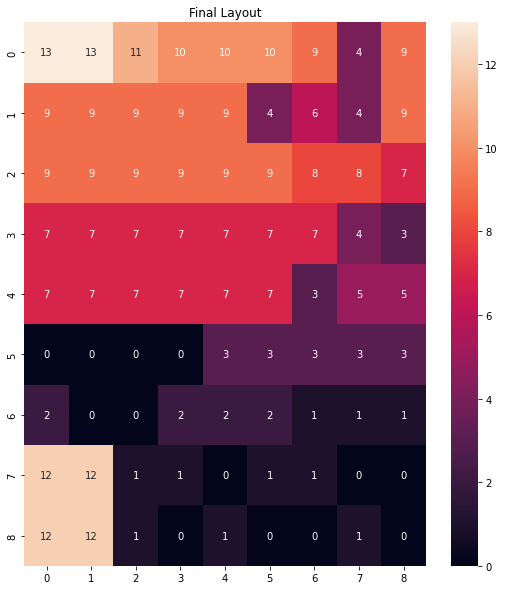

In [53]:
print(sampleset)
printout = []
for f in facilities:
    printouttemp = []
    for p in positions:
        label = f'F{f}P{p}'
        value = sampleset.first.sample[label]
        printouttemp.append(value) 
    printout.append(printouttemp)
# print(np.array(printout))
# print("\n",sampleset)


layout = np.zeros((matrL,matrL))
ctr = 1
for i in printout:
    for j in range(len(i)):
        if i[j] == 1:
            q = int(j/len(layout))
            r = j%len(layout)
            layout[q][r] = ctr
    ctr+=1
# print(layout)
# print("fitness = ",fitness(layout))
fig, ax = plt.subplots(figsize=(9, 10))
sns.heatmap(layout,annot = layout, vmin = 0, vmax = len(facilities)).set(title = "Final Layout")

# end = time.time()

print("\nRuntime = ", end-start)
printout = np.array(printout)
for i in range(len(printout)):
    true_size = facility_size[i]
    calc_size = np.sum(printout[i])
    if true_size == calc_size:
        print("Facility ", i+1, "\t correct size of", true_size, "\n")
    else:
        print("Facility ", i+1, "\t wrong size.", "True Size = ", true_size, "Calc size = ", calc_size,"\n")
ctr1 = 0
for i in range(len(printout.T)):
    if np.sum(printout.T[i]) >1:
        print("Position ", i+1, " = Overlapped")
    else:
        ctr1+=1

if ctr1 == 81:
    print("No Overlaps")

[Text(0.5, 1.0, 'Final Matrix')]

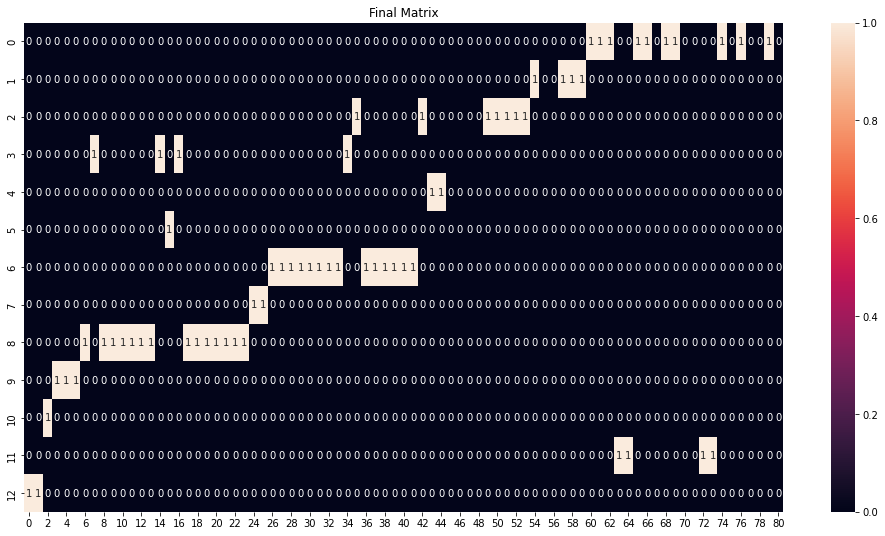

In [54]:
fig, ax = plt.subplots(figsize=(17, 9))
sns.heatmap(printout,annot = printout, vmax= 1, vmin=0 ).set(title = "Final Matrix")
